# Neural networks
We move from a linear model to a model based on a neural network that can fit any function, linear or non linear, depending on its number of parameters. PyTorch provides a module that implements all the components required to build a neural network: parameters, linear transformation (using weights and bias parameters), activation functions for the non-linearity. 

In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn

## Linear models in PyTorch
In order to see what is avaliable in PyTorch we will build a linear model using a PyTorch module instead of creating one. Once we have seen the modules available in PyTorch to build models we will see how to build one using a neural network. We use the same temperature data seen in ch.5

In [ ]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) 
t_u = torch.tensor(t_u).unsqueeze(1) 
t_u.shape

torch.Size([11, 1])

We split the data into two subsets: a training set and a validation set by shuffling the indices

In [ ]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 5,  6,  1,  8,  7, 10,  2,  9,  0]), tensor([4, 3]))

With the indices we can create the two subsets and also apply a normalization of the data

In [ ]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

We create a linear model, using the PyTorch module, with only one parameter (the weight), one output value, and one (default) bias.

In [ ]:
num_weights = 1
num_output = 1
linear_model = nn.Linear(num_weights, num_output)
linear_model(t_un_val)

tensor([[4.9743],
        [7.1240]], grad_fn=<AddmmBackward0>)

In [ ]:
linear_model.weight

Parameter containing:
tensor([[0.8397]], requires_grad=True)

In [ ]:
linear_model.bias

Parameter containing:
tensor([0.2467], requires_grad=True)

We can apply our linear model, built using the PyTorch module, to a batch of data points

In [ ]:
batch_size = 10
input_features = 1 # weight
x = torch.ones(batch_size, input_features)
linear_model(x)

tensor([[1.0864],
        [1.0864],
        [1.0864],
        [1.0864],
        [1.0864],
        [1.0864],
        [1.0864],
        [1.0864],
        [1.0864],
        [1.0864]], grad_fn=<AddmmBackward0>)

We will follow the same approach when we will build a batch of images with the three RGB channels and their width and height. Now we use the same training loop that we used with our own linear model but this time we use the linear model implementation available in the nn PyTorch module

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) 
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) 
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() 
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

We use the same loss function (mean square errors) to be minimized using an optimization algorithm such as Stochastic Gradient Descent (SGD)

In [ ]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [ ]:
linear_model = nn.Linear(1, 1) 
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

Epoch 1, Training loss 76.6742, Validation loss 301.1889
Epoch 1000, Training loss 4.0647, Validation loss 9.3708
Epoch 2000, Training loss 2.9659, Validation loss 4.2739
Epoch 3000, Training loss 2.9138, Validation loss 3.5676


After the training, we can print the parameters that have been learnt by our linear model, that is the weight and the bias

In [ ]:
print(linear_model.weight)
print(linear_model.bias)

Parameter containing:
tensor([[5.1659]], requires_grad=True)
Parameter containing:
tensor([-16.2595], requires_grad=True)


We can also use the the mean square errors loss function implemented in the nn module of PyTorch instead of passing our own implementation.

In [ ]:
linear_model = nn.Linear(1, 1) 
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # mean square errors loss function implemented in PyTorch
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

Epoch 1, Training loss 259.3491, Validation loss 798.4213
Epoch 1000, Training loss 3.9613, Validation loss 8.9878
Epoch 2000, Training loss 2.9610, Validation loss 4.2285
Epoch 3000, Training loss 2.9135, Validation loss 3.5595


The result is of course similar to what we got using our loss function implementation

In [ ]:
print(linear_model.weight)
print(linear_model.bias)

Parameter containing:
tensor([[5.1675]], requires_grad=True)
Parameter containing:
tensor([-16.2678], requires_grad=True)


## Neural networks in PyTorch
After we have seen how to build, train, and use a linear model using some modules available in PyTorch we will see how to build a neural network, with an input layer, a hidden layer, and an output layer. We will use the neural network model to solve the same temperature conversion problem so we will be able to see whether a solution based on a neural netowork can be used to address a regression task. We build a simple neural network with one unit for the input layer, 13 units for the hidden layer, and one unit for the ouput layer. The input unit is connected to each of the 13 units of the hidden layers and they are all connected to the output layer. We use the Tanh() function as the activation function of the units in the hidden layer. Our neural network is built as a sequence of the input layer, the activation function of the units in the hidden layer, and the output layer. 

In [ ]:
seq_model = nn.Sequential(
  nn.Linear(1, 13),
  nn.Tanh(),
  nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [ ]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
  n_epochs = 5000,
  optimizer = optimizer,
  model = seq_model,
  loss_fn = nn.MSELoss(),
  t_u_train = t_un_train,
  t_u_val = t_un_val,
  t_c_train = t_c_train,
  t_c_val = t_c_val)

Epoch 1, Training loss 132.2358, Validation loss 461.0046
Epoch 1000, Training loss 3.9295, Validation loss 37.6054
Epoch 2000, Training loss 2.7013, Validation loss 18.7500
Epoch 3000, Training loss 2.3449, Validation loss 12.1683
Epoch 4000, Training loss 2.1943, Validation loss 8.7160
Epoch 5000, Training loss 2.1230, Validation loss 6.7429


Since our neural network model has 13 parameters and not only two as in the linear model we cannot compare the two models using the parameters value but we can plot the output for different inputs

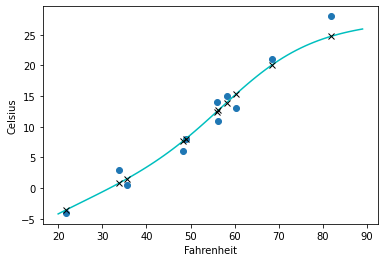

In [ ]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

We can see that our model, with its 13 parameters, overfits the data and instead of a linear relationship between Fahrenheit and Celsius we can see a non-linear one. In any case the neural network model fits the data quite well.